In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import StratifiedKFold, GridSearchCV, train_test_split
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, LSTM, Dropout, Input, BatchNormalization, Layer
from tensorflow.keras.regularizers import l2
from scikeras.wrappers import KerasClassifier
import tensorflow as tf
from tensorflow.keras.layers import Bidirectional

# Load your dataset
data = pd.read_csv("B:/Projects/PycharmProjects/PPMI_Research_on_Parkinson's/src/mahbub/finalDatasetWithUPDRSScore.csv")

# Define non-feature, numerical, and categorical columns
non_feature_columns = ['Patient ID', 'Visit Date', 'UPDRS_SCORE', 'Visit', 'Visit_int']
numerical_features = [
    'Area', 'Circularity', 'ConvexArea', 'EquivDiameter', 'Extent',
    'FilledArea', 'Kurtosis', 'Major axis length', 'Mean',
    'Minor axis length', 'PA_ratio', 'Shannon_Entropy', 'Skewness',
    'Solidity', 'Standard Deviation', 'brightness', 'contrast',
    'correlation', 'dissimilarity', 'energy', 'gabor_energy',
    'gabor_entropy', 'homogeneity', 'lbp_energy', 'lbp_entropy',
    'DATSCAN_CAUDATE_R', 'DATSCAN_CAUDATE_L', 'DATSCAN_PUTAMEN_R',
    'DATSCAN_PUTAMEN_L', 'DATSCAN_PUTAMEN_R_ANT', 'DATSCAN_PUTAMEN_L_ANT'
]
categorical_features = [
    'NP1ANXS', 'NP1APAT', 'NP1COG', 'NP1DDS', 'NP1DPRS',
    'NP1HALL', 'NP1CNST', 'NP1FATG', 'NP1LTHD', 'NP1PAIN', 'NP1SLPD',
    'NP1SLPN', 'NP1URIN', 'NP2DRES', 'NP2EAT', 'NP2FREZ', 'NP2HOBB',
    'NP2HWRT', 'NP2HYGN', 'NP2RISE', 'NP2SALV', 'NP2SPCH', 'NP2SWAL',
    'NP2TRMR', 'NP2TURN', 'NP2WALK', 'NP3BRADY', 'NP3FACXP', 'NP3FRZGT',
    'NP3FTAPL', 'NP3FTAPR', 'NP3GAIT', 'NP3HMOVL', 'NP3HMOVR', 'NP3KTRML',
    'NP3KTRMR', 'NP3LGAGL', 'NP3LGAGR', 'NP3POSTR', 'NP3PRSPL', 'NP3PRSPR',
    'NP3PSTBL', 'NP3PTRML', 'NP3PTRMR', 'NP3RIGLL', 'NP3RIGLU', 'NP3RIGN',
    'NP3RIGRL', 'NP3RIGRU', 'NP3RISNG', 'NP3RTALJ', 'NP3RTALL', 'NP3RTALU',
    'NP3RTARL', 'NP3RTARU', 'NP3RTCON', 'NP3SPCH', 'NP3TTAPL', 'NP3TTAPR',
    'NHY'
]
target_column = "Disease_Severity"

# Scale numerical features
scaler = MinMaxScaler()
data[numerical_features] = scaler.fit_transform(data[numerical_features])

# One-hot encode the target variable (Disease_Severity)
data = pd.get_dummies(data, columns=[target_column], drop_first=False)

# Extract target columns after one-hot encoding
target_columns = list(data.filter(regex='Disease_Severity').columns)

# Function to create sequences
def create_sequences(data, non_feature_columns, numerical_features, categorical_features, target_columns):
    sequences = []
    targets = []
    grouped = data.groupby('Patient ID')

    for patient_id, group in grouped:
        # Drop non-feature columns
        group = group.drop(non_feature_columns, axis=1)
        
        # Select numerical and categorical features
        patient_data = group[numerical_features + categorical_features].values
        num_visits = len(patient_data)
        
        # Ensure exactly 4 visits per patient
        if num_visits >= 4:
            sequences.append(patient_data[-4:])
        else:
            # Pad with zeros if fewer than 4 visits
            padding = np.zeros((4 - num_visits, len(numerical_features + categorical_features)))
            padded_sequence = np.concatenate([padding, patient_data])
            sequences.append(padded_sequence)
        
        # Get the target sequence (last visit class one-hot encoded)
        target = group[target_columns].values[-1]
        targets.append(target)

    # Convert lists to numpy arrays
    sequences = np.array(sequences)
    targets = np.array(targets)
    
    return sequences, targets

# Create sequences
sequences, targets = create_sequences(data, non_feature_columns, numerical_features, categorical_features, target_columns)

# Convert sequences and targets to numpy arrays
X = np.array(sequences)
y = np.array(targets)

# Reshape X to match LSTM input shape (batch_size, timesteps, features)
X = X.reshape((X.shape[0], X.shape[1], X.shape[2]))

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Define a custom attention layer
class AttentionLayer(Layer):
    def __init__(self, **kwargs):
        super(AttentionLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        self.W = self.add_weight(name='att_weight', shape=(input_shape[-1], input_shape[-1]),
                                 initializer='random_normal', trainable=True)
        self.b = self.add_weight(name='att_bias', shape=(input_shape[-1],),
                                 initializer='random_normal', trainable=True)
        super(AttentionLayer, self).build(input_shape)

    def call(self, x):
        e = tf.keras.backend.tanh(tf.keras.backend.dot(x, self.W) + self.b)
        a = tf.keras.backend.softmax(e, axis=1)
        output = x * a
        attention_weights = tf.keras.backend.sum(a, axis=1)  # Sum of attention weights for visualization
        return tf.keras.backend.sum(output, axis=1), attention_weights

# Function to create a more complex LSTM model with attention
def create_complex_lstm_with_attention(input_shape, output_shape, units=50, dropout_rate=0.5, l2_rate=0.001):
    inputs = Input(shape=input_shape)
    
    # First LSTM layer with Batch Normalization
    x = LSTM(units, return_sequences=True, kernel_regularizer=l2(l2_rate))(inputs)
    x = BatchNormalization()(x)
    x = Dropout(dropout_rate)(x)
    
    # Second bidirectional LSTM layer with Batch Normalization
    x = Bidirectional(LSTM(units, return_sequences=True, kernel_regularizer=l2(l2_rate)))(x)
    x = BatchNormalization()(x)
    x = Dropout(dropout_rate)(x)
    
    # Third LSTM layer without return_sequences
    x = LSTM(units, return_sequences=True, kernel_regularizer=l2(l2_rate))(x)
    x = BatchNormalization()(x)
    x = Dropout(dropout_rate)(x)
    
    # Attention layer
    x, attention_weights = AttentionLayer()(x)
    
    # Dense output layer
    outputs = Dense(output_shape, activation='softmax', kernel_regularizer=l2(l2_rate))(x)
    
    model = Model(inputs, outputs)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model

# Wrap Keras model for use with scikit-learn
input_shape = (X_train.shape[1], X_train.shape[2])
output_shape = y_train.shape[1]

model = KerasClassifier(model=create_complex_lstm_with_attention, input_shape=input_shape, output_shape=output_shape, verbose=0)

# Define hyperparameters for GridSearchCV
param_grid = {
    'model__units': [50, 100, 150],
    'model__dropout_rate': [0.2, 0.5],
    'model__l2_rate': [0.001, 0.01],
    'epochs': [50, 100],
    'batch_size': [32, 64]
}

# Create StratifiedKFold cross-validation object
skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

# Helper function to stratify by multilabel target
def multilabel_stratified_kfold(X, y, skf):
    stratify_labels = np.array([''.join(str(int(class_)) for class_ in row) for row in y])
    for train_idx, test_idx in skf.split(X, stratify_labels):
        yield train_idx, test_idx

# Perform GridSearchCV with StratifiedKFold
grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=list(multilabel_stratified_kfold(X, y, skf)))
grid_result = grid.fit(X, y)

# Summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params'] 
for mean, std, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, std, param))

# Evaluate the best model
best_model = grid_result.best_estimator_.model_

# Evaluate on training data
train_loss, train_acc = best_model.evaluate(X_train, y_train, verbose=0)
print(f"Training Accuracy: {train_acc:.4f}  Training Loss: {train_loss:.4f}")


# Evaluate on testing data
test_loss, test_acc = best_model.evaluate(X_test, y_test, verbose=0)
print(f"Testing Accuracy: {test_acc:.4f}  Testing Loss: {test_loss:.4f}")

# Predict using the best model
y_pred = best_model.predict(X_test)

# Extract attention weights from the model
# attention_layer = best_model.model.layers[-2]  # Access layers directly from best_model
# get_attention_weights = tf.keras.backend.function([best_model.model.input], [attention_layer.output[1]])
# 
# # Calculate attention weights for test data
# attention_weights = get_attention_weights([X_test])[0]
# 
# # Visualize or analyze attention weights as needed
# print("Attention Weights for the first sample in the test set:")
# print(attention_weights[0])  # Replace 0 with index if you want to see attention weights for a specific sample


Best: 0.517544 using {'batch_size': 64, 'epochs': 100, 'model__dropout_rate': 0.5, 'model__l2_rate': 0.01, 'model__units': 50}
0.460526 (0.037216) with: {'batch_size': 32, 'epochs': 50, 'model__dropout_rate': 0.2, 'model__l2_rate': 0.001, 'model__units': 50}
0.478070 (0.016411) with: {'batch_size': 32, 'epochs': 50, 'model__dropout_rate': 0.2, 'model__l2_rate': 0.001, 'model__units': 100}
0.425439 (0.032822) with: {'batch_size': 32, 'epochs': 50, 'model__dropout_rate': 0.2, 'model__l2_rate': 0.001, 'model__units': 150}
0.429825 (0.006203) with: {'batch_size': 32, 'epochs': 50, 'model__dropout_rate': 0.2, 'model__l2_rate': 0.01, 'model__units': 50}
0.451754 (0.031013) with: {'batch_size': 32, 'epochs': 50, 'model__dropout_rate': 0.2, 'model__l2_rate': 0.01, 'model__units': 100}
0.447368 (0.038736) with: {'batch_size': 32, 'epochs': 50, 'model__dropout_rate': 0.2, 'model__l2_rate': 0.01, 'model__units': 150}
0.442982 (0.040674) with: {'batch_size': 32, 'epochs': 50, 'model__dropout_rate'

Best: 0.517544 using {'batch_size': 64, 'epochs': 100, 'model__dropout_rate': 0.5, 'model__l2_rate': 0.01, 'model__units': 50}
0.460526 (0.037216) with: {'batch_size': 32, 'epochs': 50, 'model__dropout_rate': 0.2, 'model__l2_rate': 0.001, 'model__units': 50}
0.478070 (0.016411) with: {'batch_size': 32, 'epochs': 50, 'model__dropout_rate': 0.2, 'model__l2_rate': 0.001, 'model__units': 100}
0.425439 (0.032822) with: {'batch_size': 32, 'epochs': 50, 'model__dropout_rate': 0.2, 'model__l2_rate': 0.001, 'model__units': 150}
0.429825 (0.006203) with: {'batch_size': 32, 'epochs': 50, 'model__dropout_rate': 0.2, 'model__l2_rate': 0.01, 'model__units': 50}
0.451754 (0.031013) with: {'batch_size': 32, 'epochs': 50, 'model__dropout_rate': 0.2, 'model__l2_rate': 0.01, 'model__units': 100}
0.447368 (0.038736) with: {'batch_size': 32, 'epochs': 50, 'model__dropout_rate': 0.2, 'model__l2_rate': 0.01, 'model__units': 150}
0.442982 (0.040674) with: {'batch_size': 32, 'epochs': 50, 'model__dropout_rate'

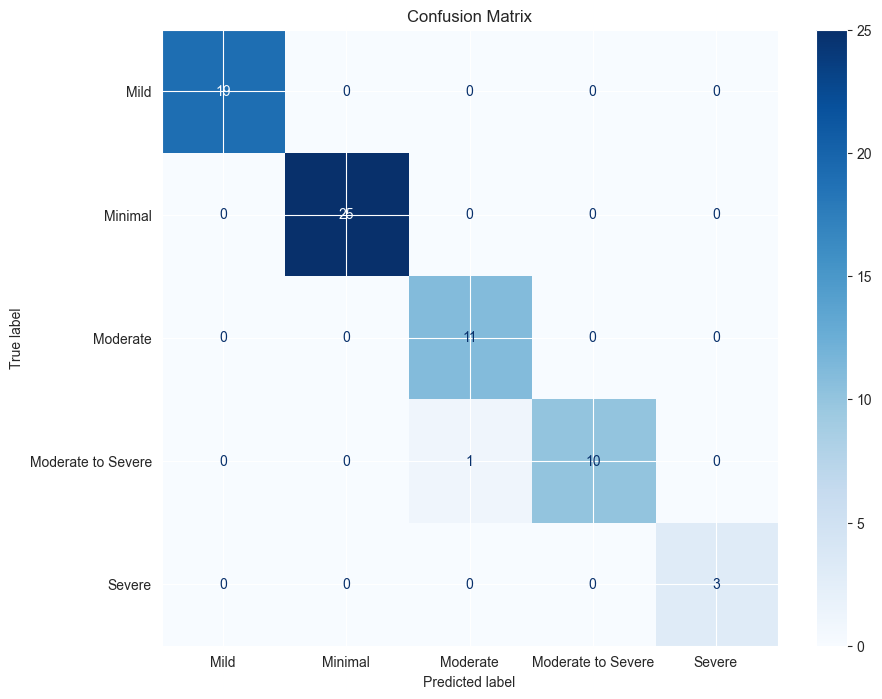

Classification Report:
                    precision    recall  f1-score   support

              Mild       1.00      1.00      1.00        19
           Minimal       1.00      1.00      1.00        25
          Moderate       0.92      1.00      0.96        11
Moderate to Severe       1.00      0.91      0.95        11
            Severe       1.00      1.00      1.00         3

          accuracy                           0.99        69
         macro avg       0.98      0.98      0.98        69
      weighted avg       0.99      0.99      0.99        69
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 284ms/step
Attention Weights for the first sample in the test set:
[0.9999999  0.99999994 0.99999994 1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.0000001  1.         1.0000001  1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.0000001  0.9999999  1.         1.
 1.         0.99999994 1.         1.         

In [2]:
  import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
from tensorflow.keras.models import Model

# Print the best parameters and score from GridSearchCV
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, std, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, std, param))

# Evaluate the best model
best_model = grid_result.best_estimator_.model_

# Evaluate on training data
train_loss, train_acc = best_model.evaluate(X_train, y_train, verbose=0)
print(f"Training Accuracy: {train_acc:.4f}  Training Loss: {train_loss:.4f}")

# Evaluate on testing data
test_loss, test_acc = best_model.evaluate(X_test, y_test, verbose=0)
print(f"Testing Accuracy: {test_acc:.4f}  Testing Loss: {test_loss:.4f}") 

# Predict using the best model
y_pred = best_model.predict(X_test)

# Convert predictions from one-hot encoding to class labels
y_test_classes = y_test.argmax(axis=1)
y_pred_classes = y_pred.argmax(axis=1)

# Define the class labels with the prefix removed
target_columns = list(data.filter(regex='Disease_Severity').columns)
cleaned_labels = [label.replace('Disease_Severity_', '') for label in target_columns]

# Calculate the confusion matrix
conf_matrix = confusion_matrix(y_test_classes, y_pred_classes)

# Increase the size of the confusion matrix plot
plt.figure(figsize=(10, 8))  # Adjust the figure size here (width=10, height=8)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=cleaned_labels[:len(set(y_test_classes))])
disp.plot(cmap=plt.cm.Blues, ax=plt.gca())
plt.title('Confusion Matrix')
plt.show()

# Print classification report
print("Classification Report:")
print(classification_report(y_test_classes, y_pred_classes, target_names=cleaned_labels[:len(set(y_test_classes))]))

# Extract attention weights from the model
attention_layer = best_model.get_layer(name='attention_layer_144')  # Ensure the name matches your AttentionLayer definition
attention_model = Model(inputs=best_model.input, outputs=attention_layer.output[1])
attention_weights = attention_model.predict(X_test)

# Visualize or analyze attention weights as needed
print("Attention Weights for the first sample in the test set:")
print(attention_weights[2])  # Replace 2 with index if you want to see attention weights for a specific sample


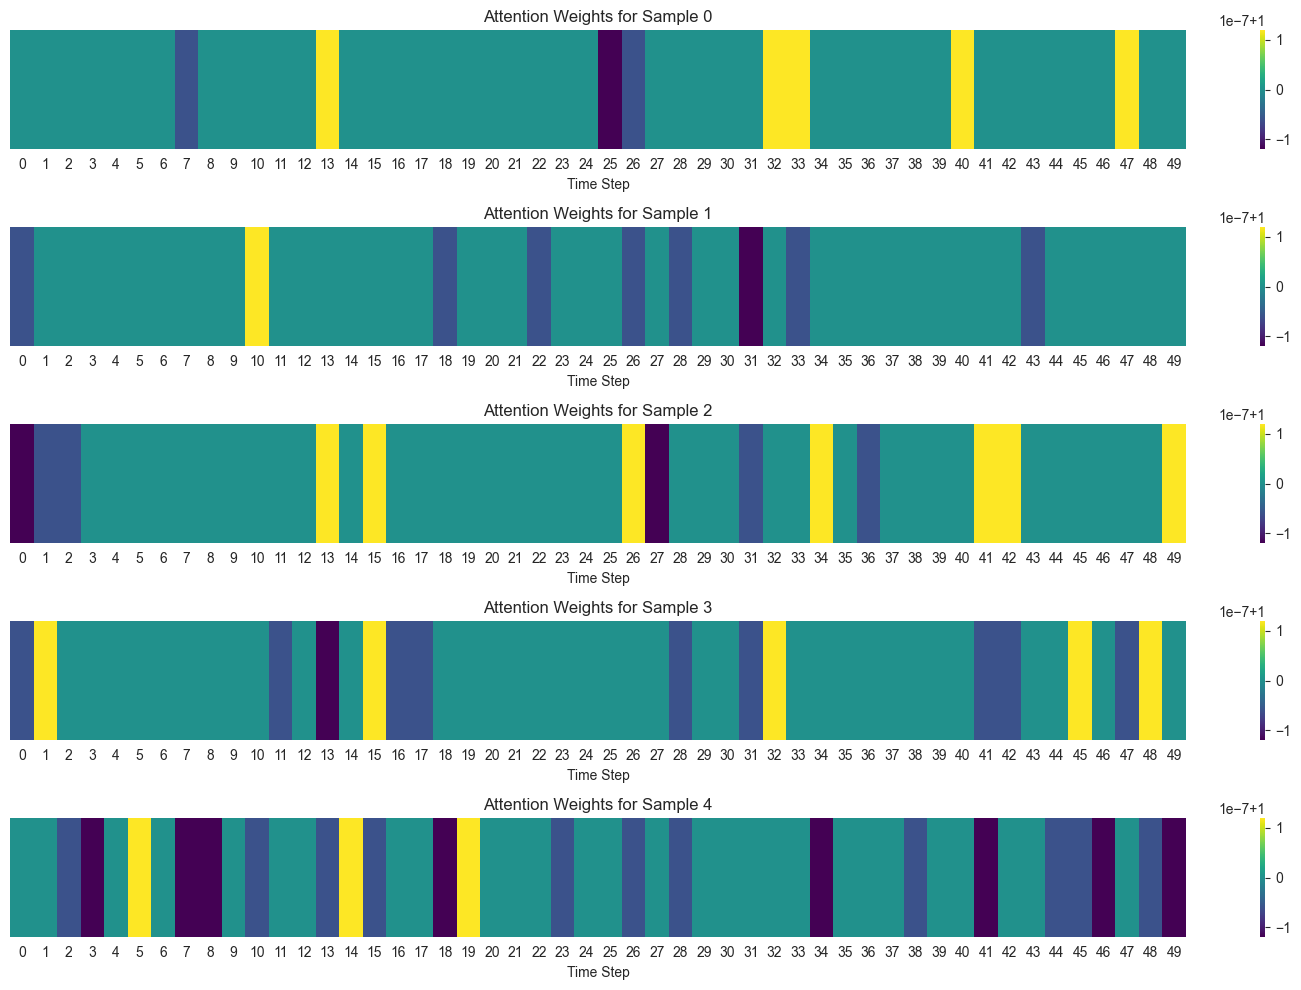

In [3]:
import numpy as np
import seaborn as sns

# Function to plot attention weights
def plot_attention_weights(attention_weights, sample_index, ax):
    sns.heatmap(np.expand_dims(attention_weights[sample_index], axis=0), cmap="viridis", cbar=True, ax=ax)
    ax.set_title(f'Attention Weights for Sample {sample_index}')
    ax.set_xlabel('Time Step')
    ax.set_yticks([])

# Plot attention weights for the first 5 samples
fig, axs = plt.subplots(5, 1, figsize=(15, 10))
for i in range(5):
    plot_attention_weights(attention_weights, i, axs[i])
plt.tight_layout()
plt.show()

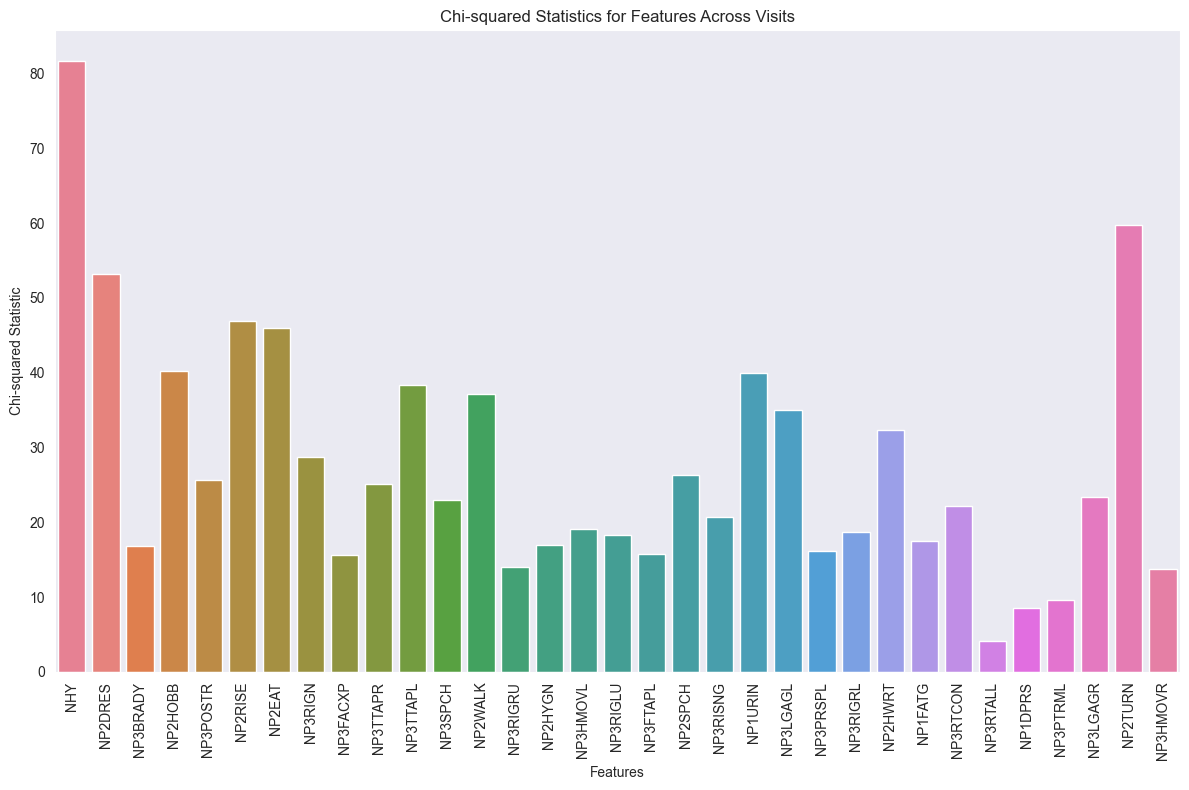

               chi2       p-value   dof
NHY       81.658753  3.469635e-11  15.0
NP2DRES   53.130932  2.760479e-08   9.0
NP3BRADY  16.835076  1.559072e-01  12.0
NP2HOBB   40.204814  6.649098e-05  12.0
NP3POSTR  25.592350  2.381262e-03   9.0
NP2RISE   46.886746  4.876923e-06  12.0
NP2EAT    45.956755  6.134435e-07   9.0
NP3RIGN   28.673577  4.403991e-03  12.0
NP3FACXP  15.610457  2.097361e-01  12.0
NP3TTAPR  25.151453  1.412127e-02  12.0
NP3TTAPL  38.316891  1.362728e-04  12.0
NP3SPCH   22.918015  6.383092e-03   9.0
NP2WALK   37.108668  2.145201e-04  12.0
NP3RIGRU  14.077193  1.196057e-01   9.0
NP2HYGN   16.927462  1.523464e-01  12.0
NP3HMOVL  19.084703  8.650472e-02  12.0
NP3RIGLU  18.270426  3.216263e-02   9.0
NP3FTAPL  15.767740  2.021071e-01  12.0
NP2SPCH   26.354042  1.787413e-03   9.0
NP3RISNG  20.725752  1.392538e-02   9.0
NP1URIN   40.011691  7.158826e-05  12.0
NP3LGAGL  35.047460  4.602277e-04  12.0
NP3PRSPL  16.166242  1.837400e-01  12.0
NP3RIGRL  18.649200  9.735331e-02  12.0


In [3]:
import pandas as pd
from scipy.stats import chi2_contingency
import matplotlib.pyplot as plt
import seaborn as sns

# Load your dataset
data = pd.read_csv("B:/Projects/PycharmProjects/PPMI_Research_on_Parkinson's/src/mahbub/finalDatasetWithUPDRSScore.csv")

# Unique set of features
features_to_test = [
    'NHY', 'NP2DRES', 'NP3BRADY', 'NP2HOBB', 'NP3POSTR', 'NP2RISE', 'NP2EAT', 
    'NP3RIGN', 'NP3FACXP', 'NP3TTAPR', 'NP3TTAPL', 'NP3SPCH', 'NP2WALK', 'NP3RIGRU',
    'NP2HYGN', 'NP3HMOVL', 'NP3RIGLU', 'NP3FTAPL', 'NP2SPCH', 'NP3RISNG', 'NP1URIN',
    'NP3LGAGL', 'NP3PRSPL', 'NP3RIGRL', 'NP2HWRT', 'NP1FATG', 'NP3RTCON', 'NP3RTALL', 
    'NP1DPRS', 'NP3PTRML', 'NP3RTCON', 'NP3TTAPL', 'NP3LGAGR', 'NP2TURN', 'NP3HMOVR'
]

# Initialize a dictionary to store the results
chi_squared_results = {}

# Loop over each feature and perform the Chi-squared test across 'Visit'
for feature in features_to_test:
    # Create a contingency table (cross-tabulation) for the feature and 'Visit'
    contingency_table = pd.crosstab(data[feature], data['Visit'])
    
    # Perform the Chi-squared test
    chi2, p, dof, expected = chi2_contingency(contingency_table)
    
    # Store the results
    chi_squared_results[feature] = {'chi2': chi2, 'p-value': p, 'dof': dof}

# Convert the results into a DataFrame for better readability
chi_squared_df = pd.DataFrame(chi_squared_results).T

# Plotting the Chi-squared statistics for each feature
plt.figure(figsize=(12, 8))

# Assign hue to the x-axis and disable the legend
sns.barplot(x=chi_squared_df.index, y=chi_squared_df['chi2'], hue=chi_squared_df.index, legend=False)

# Rotate the x labels for better readability
plt.xticks(rotation=90)
plt.title("Chi-squared Statistics for Features Across Visits")
plt.xlabel("Features")
plt.ylabel("Chi-squared Statistic")
plt.grid(False)
plt.tight_layout()

# Show the plot
plt.show()

# Save the results to CSV (if needed)
chi_squared_df.to_csv("chi_squared_results.csv")

# Print results
print(chi_squared_df)


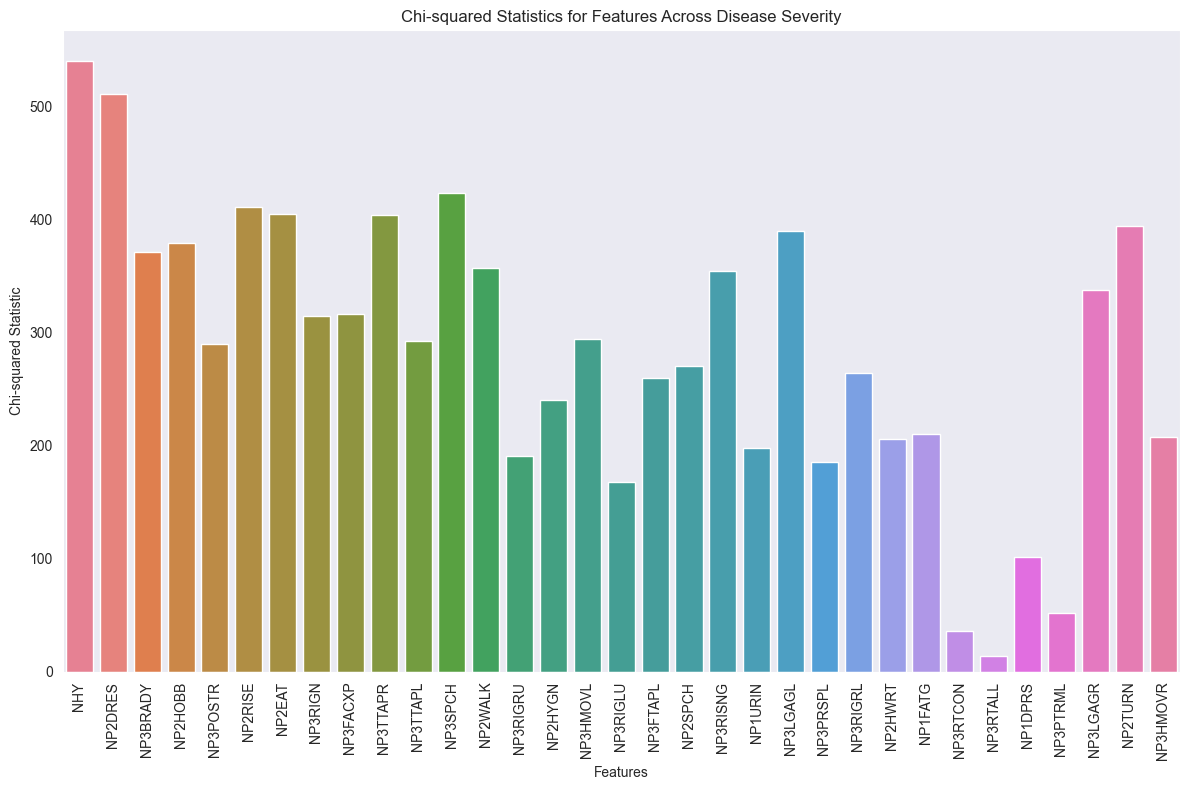

                chi2       p-value   dof
NHY       540.199989  3.484928e-98  25.0
NP2DRES   511.349486  2.243090e-99  15.0
NP3BRADY  371.573900  1.572418e-66  20.0
NP2HOBB   379.687716  3.300963e-68  20.0
NP3POSTR  290.088499  6.389553e-53  15.0
NP2RISE   411.474234  8.489511e-75  20.0
NP2EAT    404.881360  6.516780e-77  15.0
NP3RIGN   315.078133  6.664338e-55  20.0
NP3FACXP  316.767041  3.004502e-55  20.0
NP3TTAPR  403.670712  3.539464e-73  20.0
NP3TTAPL  292.258109  3.070624e-50  20.0
NP3SPCH   423.260917  8.864753e-81  15.0
NP2WALK   357.187735  1.469017e-63  20.0
NP3RIGRU  191.237273  1.273428e-32  15.0
NP2HYGN   240.482213  9.421985e-40  20.0
NP3HMOVL  294.408852  1.118542e-50  20.0
NP3RIGLU  167.692619  7.097554e-28  15.0
NP3FTAPL  259.657459  1.281182e-43  20.0
NP2SPCH   270.160527  8.577310e-49  15.0
NP3RISNG  354.151300  2.844906e-66  15.0
NP1URIN   198.402185  2.329344e-31  20.0
NP3LGAGL  390.248100  2.148487e-70  20.0
NP3PRSPL  185.661699  7.538570e-29  20.0
NP3RIGRL  264.60

In [4]:
import pandas as pd
from scipy.stats import chi2_contingency
import matplotlib.pyplot as plt
import seaborn as sns

# Load your dataset
data = pd.read_csv("B:/Projects/PycharmProjects/PPMI_Research_on_Parkinson's/src/mahbub/finalDatasetWithUPDRSScore.csv")

# Unique set of features
features_to_test = [
    'NHY', 'NP2DRES', 'NP3BRADY', 'NP2HOBB', 'NP3POSTR', 'NP2RISE', 'NP2EAT', 
    'NP3RIGN', 'NP3FACXP', 'NP3TTAPR', 'NP3TTAPL', 'NP3SPCH', 'NP2WALK', 'NP3RIGRU',
    'NP2HYGN', 'NP3HMOVL', 'NP3RIGLU', 'NP3FTAPL', 'NP2SPCH', 'NP3RISNG', 'NP1URIN',
    'NP3LGAGL', 'NP3PRSPL', 'NP3RIGRL', 'NP2HWRT', 'NP1FATG', 'NP3RTCON', 'NP3RTALL', 
    'NP1DPRS', 'NP3PTRML', 'NP3RTCON', 'NP3TTAPL', 'NP3LGAGR', 'NP2TURN', 'NP3HMOVR'
]

# Initialize a dictionary to store the results
chi_squared_results = {}

# Loop over each feature and perform the Chi-squared test across 'Visit'
for feature in features_to_test:
    # Create a contingency table (cross-tabulation) for the feature and 'Visit'
    contingency_table = pd.crosstab(data[feature], data['Disease_Severity'])
    
    # Perform the Chi-squared test
    chi2, p, dof, expected = chi2_contingency(contingency_table)
    
    # Store the results
    chi_squared_results[feature] = {'chi2': chi2, 'p-value': p, 'dof': dof}

# Convert the results into a DataFrame for better readability
chi_squared_df = pd.DataFrame(chi_squared_results).T

# Plotting the Chi-squared statistics for each feature
plt.figure(figsize=(12, 8))

# Assign hue to the x-axis and disable the legend
sns.barplot(x=chi_squared_df.index, y=chi_squared_df['chi2'], hue=chi_squared_df.index, legend=False)

# Rotate the x labels for better readability
plt.xticks(rotation=90)
plt.title("Chi-squared Statistics for Features Across Disease Severity")
plt.xlabel("Features")
plt.ylabel("Chi-squared Statistic")
plt.grid(False)
plt.tight_layout()

# Show the plot
plt.show()

# Save the results to CSV (if needed)
chi_squared_df.to_csv("chi_squared_results.csv")

# Print results
print(chi_squared_df)


In [5]:
import pandas as pd

# Load the dataset
data = pd.read_csv("B:/Projects/PycharmProjects/PPMI_Research_on_Parkinson's/src/mahbub/finalDatasetWithUPDRSScore.csv")
target_column = "Disease_Severity"
# Group by Visit and Disease Severity, counting unique Patient IDs
severity_counts = data.groupby(['Visit', target_column])['Patient ID'].nunique().reset_index()

# Calculate total number of patients for each visit
total_patients_per_visit = severity_counts.groupby('Visit')['Patient ID'].sum().reset_index()
total_patients_per_visit.rename(columns={'Patient ID': 'Total_Patients'}, inplace=True)

# Merge to get total patients back into the severity_counts DataFrame
severity_counts = severity_counts.merge(total_patients_per_visit, on='Visit')

# Calculate the percentage of patients in each severity level
severity_counts['Percentage'] = (severity_counts['Patient ID'] / severity_counts['Total_Patients']) * 100

# Format the output
output = severity_counts.pivot(index='Visit', columns=target_column, values='Percentage').fillna(0)

# Display the results
print(output)


Disease_Severity       Mild    Minimal   Moderate  Moderate to Severe  \
Visit                                                                   
V1                36.403509  13.596491  38.157895            8.333333   
V2                34.649123   4.385965  35.964912           18.421053   
V3                34.210526   3.508772  35.087719           18.421053   
V4                17.982456   1.754386  42.543860           22.807018   

Disease_Severity    Severe  Very Severe  
Visit                                    
V1                3.508772     0.000000  
V2                5.263158     1.315789  
V3                7.456140     1.315789  
V4                9.210526     5.701754  


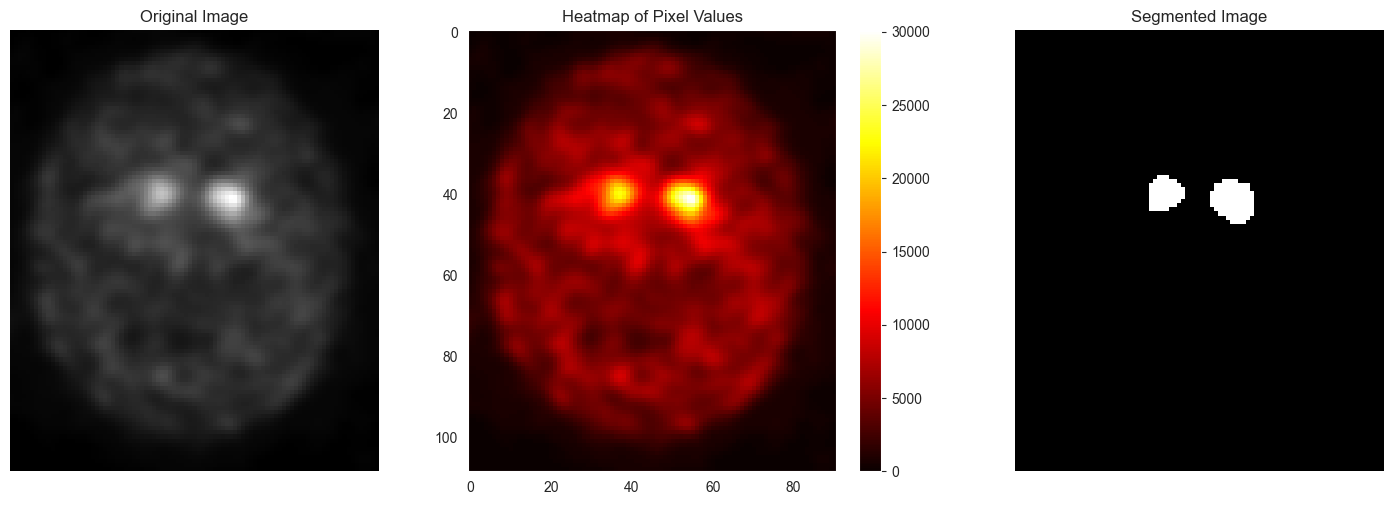

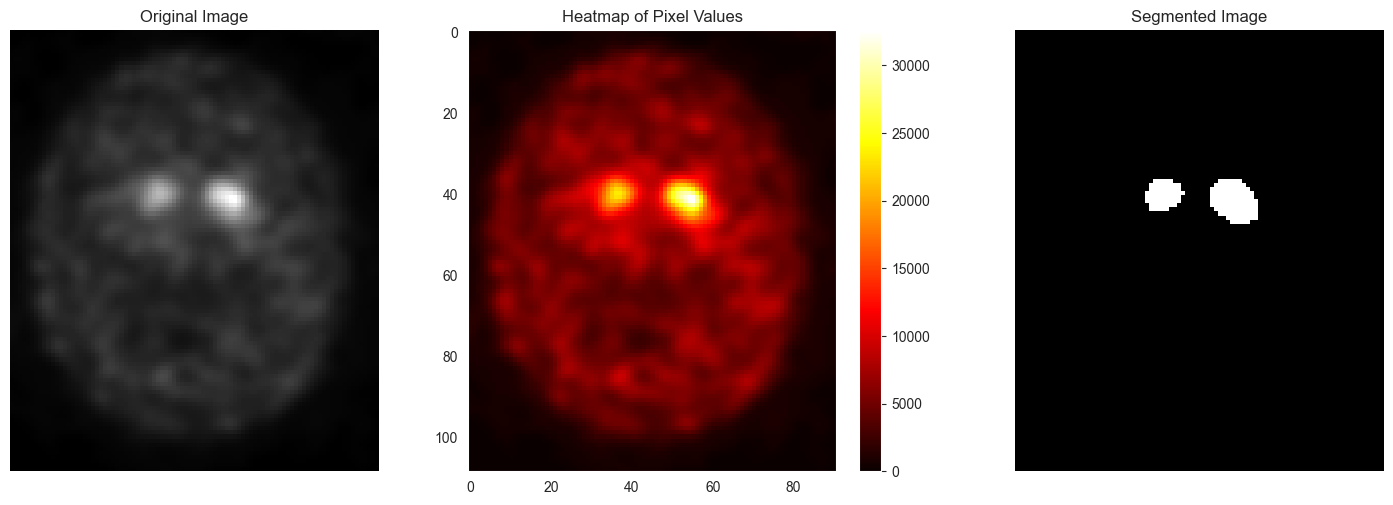

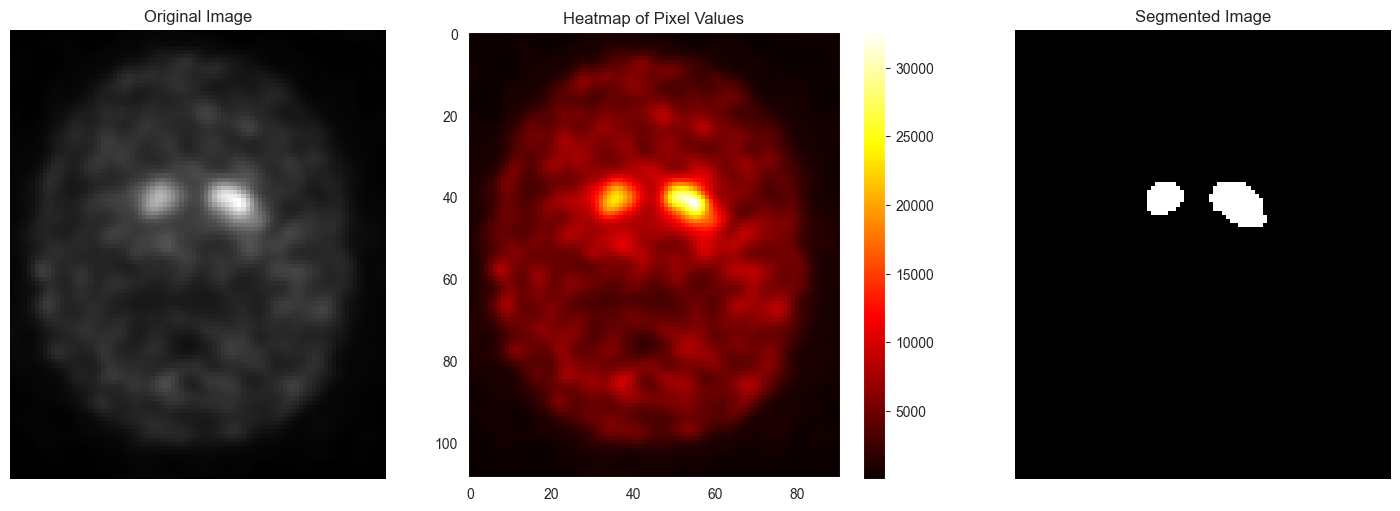

In [14]:
import numpy as np
import pydicom
import os
from sklearn.cluster import KMeans
from PIL import Image
import matplotlib.pyplot as plt

def load_dicom_images(dicom_dir):
    # Get list of DICOM files in the directory
    dicom_files = sorted([os.path.join(dicom_dir, file) for file in os.listdir(dicom_dir) if file.endswith('.dcm')])
    try:
        # Read DICOM files and stack pixel arrays into a 3D array
        dicom_data = [pydicom.dcmread(file) for file in dicom_files]
        preprocessed_image_data = np.stack([dicom.pixel_array for dicom in dicom_data])
        # Remove single channel dimension if present
        preprocessed_image_data = np.squeeze(preprocessed_image_data)
        return preprocessed_image_data
    except Exception as e:
        print("Error loading DICOM data:", e)
        return None

def kmeans_segment(image_array, num_clusters, threshold=None):
    # Apply threshold if provided
    if threshold is not None:
        image_array[image_array < threshold] = 0

    # Flatten the image array to a 2D array of pixels
    pixels = image_array.reshape((-1, 1))  # Assuming a single-channel image (grayscale)

    # Initialize KMeans model
    kmeans = KMeans(n_clusters=num_clusters, random_state=42)

    # Fit KMeans model to the pixels
    kmeans.fit(pixels)

    # Get the labels and cluster centers
    labels = kmeans.labels_
    cluster_centers = kmeans.cluster_centers_

    brightest_cluster_center = np.argmax(cluster_centers)
    modified_cluster_centers = np.zeros_like(cluster_centers)
    # Set the brightest cluster center to its original value
    modified_cluster_centers[brightest_cluster_center] = cluster_centers[brightest_cluster_center]

    # Create a new image with the pixel values replaced by cluster centers
    segmented_img_array = modified_cluster_centers[labels].reshape(image_array.shape).astype(np.uint8)

    return segmented_img_array

import matplotlib.pyplot as plt
import numpy as np

def display_images(original_image, segmented_image, a):
    # Display original, segmented images and the heatmap side by side
    plt.figure(figsize=(15, 5))  # Adjust the figure size

    # First subplot: Original Image
    plt.subplot(1, 3, 1)  # Create a 1x3 grid, 1st position
    plt.title("Original Image")
    plt.imshow(original_image, cmap='gray')
    plt.axis('off')
    
     # Third subplot: Heatmap of pixel values
    if isinstance(original_image, np.ndarray):
        # If the input is a NumPy array, directly use it
        pixels = original_image
    else:
        # Convert to grayscale if the input is a Pillow Image
        img = original_image.convert('L')
        pixels = np.array(img)

    plt.subplot(1, 3, 2)  # Create a 1x3 grid, 3rd position
    plt.imshow(pixels, cmap='hot', interpolation='nearest')
    plt.colorbar()
    plt.title('Heatmap of Pixel Values')
    plt.grid(False)


    # Second subplot: Segmented Image
    plt.subplot(1, 3, 3)  # Create a 1x3 grid, 2nd position
    plt.title("Segmented Image")
    plt.imshow(segmented_image, cmap='gray')
    plt.axis('off')

    # Adjust layout for better spacing
    plt.tight_layout()
    plt.show()

    
def plot_heatmap(img):
    if isinstance(img, np.ndarray):
        # If the input is a NumPy array, directly convert it to grayscale if needed
        pixels = img
    else:
        # Convert to grayscale if the input is a Pillow Image
        img = img.convert('L')
        pixels = np.array(img)
    
    # Plot the heatmap
    plt.figure(figsize=(8, 6))
    plt.imshow(pixels, cmap='hot', interpolation='nearest')
    plt.colorbar()
    plt.title('Heatmap of Pixel Values')
    plt.grid(False)
    plt.show()

    
    
# Set the directory containing DICOM files
dicom_dir = r'B:\Sami Sir Research\Data set\Final Dataset v2\four_v\3010\Reconstructed_DaTSCAN\2011-07-13_15_33_38.0\I341197'

# Load the DICOM images
dicom_images = load_dicom_images(dicom_dir)

if dicom_images is not None:
    # Select a slice (e.g., the first slice)
    original_slice_1 = dicom_images[37]
    original_slice_2 = dicom_images[38]
    original_slice_3 = dicom_images[39]
    

    # Perform KMeans segmentation
    num_clusters = 4  # Set the desired number of clusters
    segmented_slice_1 = kmeans_segment(original_slice_1, num_clusters)
    segmented_slice_2 = kmeans_segment(original_slice_2, num_clusters)
    segmented_slice_3 = kmeans_segment(original_slice_3, num_clusters)

    # Display the original and segmented images side by side
    display_images(original_slice_1, segmented_slice_1,37)
    display_images(original_slice_2, segmented_slice_2,38)
    display_images(original_slice_3, segmented_slice_3,39)


In [ ]:
# List of directories containing DICOM files
dicom_dirs = [
    r'B:\Sami Sir Research\Data set\Final Dataset v2\four_v\3010\Reconstructed_DaTSCAN\2011-07-13_15_33_38.0\I341197',
    r'B:\Sami Sir Research\Data set\Final Dataset v2\four_v\3010\Reconstructed_DaTSCAN\2012-06-26_15_03_38.0\I418332',
    r'B:\Sami Sir Research\Data set\Final Dataset v2\four_v\3010\Reconstructed_DaTSCAN\2013-07-17_14_38_02.0\I419654',
    r'B:\Sami Sir Research\Data set\Final Dataset v2\four_v\3010\Reconstructed_DaTSCAN\2015-06-26_14_31_06.0\I1331436'
]

# Number of clusters for segmentation
num_clusters = 5

# Process each directory in the list
for idx, dicom_dir in enumerate(dicom_dirs):
    # Load the DICOM images from the directory
    dicom_images = load_dicom_images(dicom_dir)
    
    if dicom_images is not None:
        # Select a slice (e.g., the 40th slice, adjust if needed)
        original_slice = dicom_images[39]  # Adjust index as needed
        
        # Perform KMeans segmentation on the slice
        segmented_slice = kmeans_segment(original_slice, num_clusters)
        
        # Display the original and segmented images, with heatmap, side by side
        print(f"Displaying for directory {idx + 1}: {dicom_dir}")
        display_images(original_slice, segmented_slice, 37)


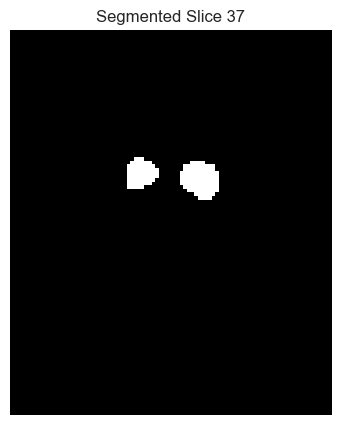

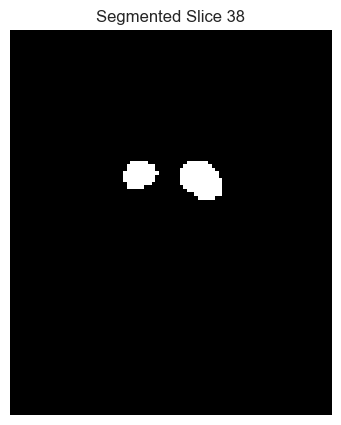

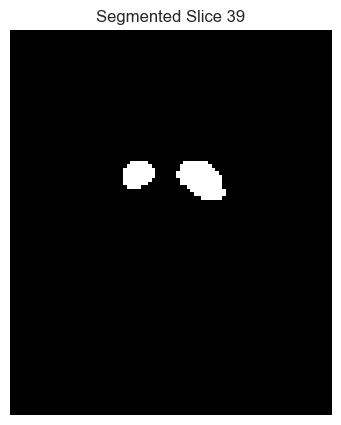

In [17]:
# Second subplot: Segmented Image
import matplotlib.pyplot as plt

# Assuming segmented_slice_1 is already defined and contains your image data
plt.figure(figsize=(5, 5))  # Set figure size
plt.title("Segmented Slice 37")  # Title of the plot
plt.imshow(segmented_slice_1, cmap='gray')  # Display the image in grayscale
plt.axis('off')  # Turn off axis
plt.show()  # Show the plot

plt.figure(figsize=(5, 5))  # Set figure size
plt.title("Segmented Slice 38")  # Title of the plot
plt.imshow(segmented_slice_2, cmap='gray')  # Display the image in grayscale
plt.axis('off')  # Turn off axis
plt.show() 

plt.figure(figsize=(5, 5))  # Set figure size
plt.title("Segmented Slice 39")  # Title of the plot
plt.imshow(segmented_slice_3, cmap='gray')  # Display the image in grayscale
plt.axis('off')  # Turn off axis
plt.show() 